<a href="https://colab.research.google.com/github/Akage1234/Pytorch-mini-projects/blob/main/NLP/Transformer/Finetuning_GPT_for_Text_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning GPT for Text Generation

## Load Dataset

In [1]:
import torch

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [7]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt -O shakespeare.txt

from datasets import Dataset
with open("shakespeare.txt") as f:
    text = f.read().split("\n\n")

dataset = Dataset.from_dict({"text": text})
dataset = dataset.train_test_split(test_size=0.1)

--2025-10-22 14:55:07--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘shakespeare.txt’

shakespeare.txt     100%[===================>]   1.06M  --.-KB/s    in 0.05s   

2025-10-22 14:55:07 (22.6 MB/s) - ‘shakespeare.txt’ saved [1115394/1115394]



In [8]:
from datasets import load_dataset
from transformers import GPT2TokenizerFast, GPT2LMHeadModel, DataCollatorForLanguageModeling, Trainer, TrainingArguments

## preprocess

In [9]:
# def filter_function(example):
#     return len(example["text"].strip()) > 10

# dataset = dataset.filter(filter_function)

In [43]:
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

In [44]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding='max_length', max_length=128)

tokenized_datasets = dataset.map(tokenize_function,batched=True, remove_columns=['text'])

Map:   0%|          | 0/6499 [00:00<?, ? examples/s]

Map:   0%|          | 0/723 [00:00<?, ? examples/s]

In [45]:
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

In [46]:
model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
model.resize_token_embeddings(len(tokenizer))

Embedding(50257, 768)

In [47]:
training_args = TrainingArguments(
    output_dir = './gpt2-shakespeare',
    eval_strategy="epoch",
    eval_steps=100,
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    save_total_limit=5,
    logging_steps=100,
    push_to_hub=False,
    fp16=True,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    warmup_steps=500,
    gradient_accumulation_steps=2
)

## Train/FineTune

In [48]:
from transformers import EarlyStoppingCallback
trainer = Trainer(
    model = model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['test'],
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

In [49]:
import os
os.environ["WANDB_DISABLED"] = "true"

trainer.train()

Epoch,Training Loss,Validation Loss
1,3.726000,3.576941
2,3.461800,3.430120
3,3.290200,3.385826
4,3.181800,3.373533
5,3.085400,3.374576


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=2035, training_loss=3.420104436850958, metrics={'train_runtime': 767.2943, 'train_samples_per_second': 42.35, 'train_steps_per_second': 2.652, 'total_flos': 2122671144960000.0, 'train_loss': 3.420104436850958, 'epoch': 5.0})

In [50]:
trainer.save_model('./gpt2-shakespeare')
tokenizer.save_pretrained('./gpt2-shakespeare')

('./gpt2-shakespeare/tokenizer_config.json',
 './gpt2-shakespeare/special_tokens_map.json',
 './gpt2-shakespeare/vocab.json',
 './gpt2-shakespeare/merges.txt',
 './gpt2-shakespeare/added_tokens.json',
 './gpt2-shakespeare/tokenizer.json')

## Testing

In [51]:
from transformers import pipeline

model_path = "./gpt2-shakespeare"

text_gen = pipeline("text-generation", model=model, tokenizer=tokenizer, device=device)

Device set to use cuda


In [52]:
while True:
    prompt = input("\nEnter a sentence for Shakespeare (type 'quit' to exit): ")
    if prompt.lower() == "quit":
        break
    output = text_gen(prompt, max_length=80, num_return_sequences=1, temperature=0.9, top_p=0.95)
    print(f"\n{output[0]['generated_text']}")


Enter a sentence for Shakespeare (type 'quit' to exit): What shall


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



What shall we have?
We must have them make our way from thence,
Or else they have no choice but to follow us.
If we come here, let's be ready to send:
No doubt, the city is to be dispersed.
Let us leave her to us in her own.
We cannot bear so much, till we are come,
And are at our own peril.
We'll have men that will make haste to our way,
And have no means to leave. For our reasons,
We will fight; and I doubt not.
The king shall say 'tis a great shame
And not a joyful one; he shall have no cause
To hear our complainations.
And when we are to leave, let's go home to supper,
As we may have such a happy time
In our own home, that our friends will come up again.
We will have men to be our friends, too,
And they must have arms. Their weapons, we say, shall make them friends:
And in those arms shall we be our friends.
But what, we shall not have arms? If we will, we are our enemies.
We shall have none, but we shall have none. Therefore

Enter a sentence for Shakespeare (type 'quit' to exit)

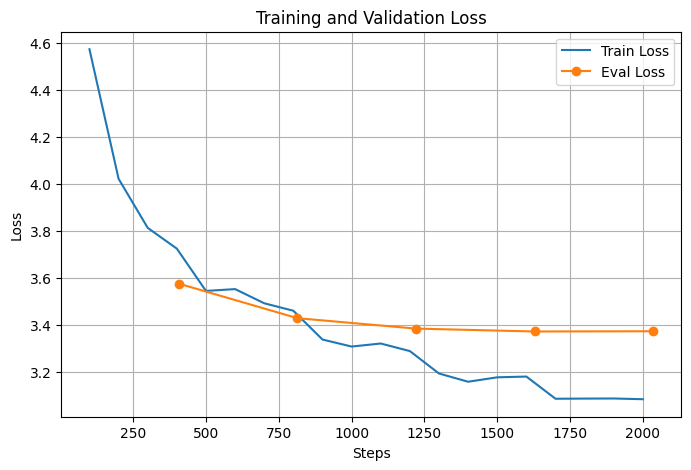

In [53]:
import matplotlib.pyplot as plt

# Extract logs from the trainer
history = trainer.state.log_history

train_steps = [x['step'] for x in history if 'loss' in x]
train_loss = [x['loss'] for x in history if 'loss' in x]

eval_steps = [x['step'] for x in history if 'eval_loss' in x]
eval_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]

# Plot properly aligned curves
plt.figure(figsize=(8,5))
plt.plot(train_steps, train_loss, label='Train Loss')
plt.plot(eval_steps, eval_loss, label='Eval Loss', marker='o')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [54]:
model.eval()
prompts = [
    "To be, or not to be, that is the",
    "My dearest Juliet, thou art the",
    "O brave new world, that has such",
    "The night was dark and full of",
    "In fair Verona, where we lay our"
]
generated_texts = []
for prompt in prompts:
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(
        **inputs,
        max_new_tokens=50,
        temperature=0.8,
        top_p=0.9,
        do_sample=True
    )
    text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    generated_texts.append(text)

for i, t in enumerate(generated_texts[:3]):
    print(f"\n=== Sample {i+1} ===\n{t}\n")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



=== Sample 1 ===
To be, or not to be, that is the question.
But to what end?--and is the issue not of the
changing of an old king?--'Tis to the succession of a
new king. This is the point, and the meaning, of
the matter,


=== Sample 2 ===
My dearest Juliet, thou art the first to be so
committed. I was told that the king was coming home,
and thou shalt know when. I'll tell thee first: I will
tell thee then: I am a good gentleman and
poor woman. You are


=== Sample 3 ===
O brave new world, that has such a man!
To this man's joy hath my heart
That I should be an instrument of my pleasure.
I have the fortune to meet him. I will go to him.
Where is your servant? and how is he?




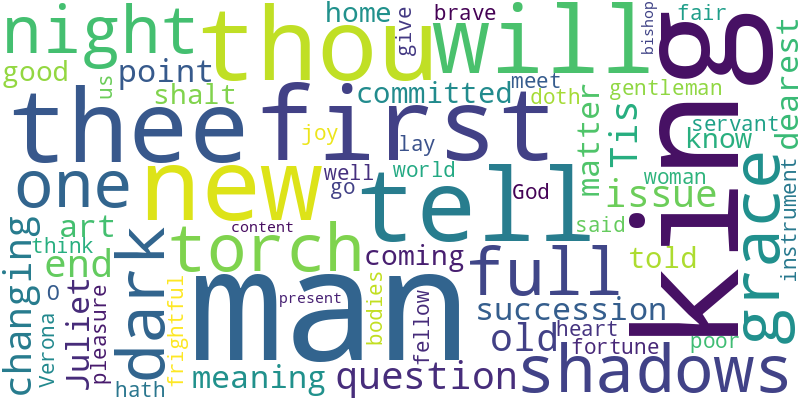

In [55]:
from wordcloud import WordCloud
text = " ".join(generated_texts)
WordCloud(width=800, height=400, background_color='white').generate(text).to_image()

In [56]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 3.373533248901367, 'eval_runtime': 4.1335, 'eval_samples_per_second': 174.91, 'eval_steps_per_second': 22.015, 'epoch': 5.0}
